## Create target variables for time series modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.signal._peak_finding import _boolrelextrema

from functions import *

In [2]:
btc_data = pd.read_parquet('btc_numeric_data.parquet.gzip')
eth_data = pd.read_parquet('eth_numeric_data.parquet.gzip')

### Create differenced price target

In [3]:
btc_targets = pd.DataFrame(index = btc_data.index)
btc_targets['btc_price_absolute_change'] = np.diff(btc_data.btc_price_close, prepend=float('nan'))
btc_targets['btc_price_relative_change'] = ((btc_data.btc_price_close / btc_data.btc_price_close.shift(1)) - 1) * 100
btc_targets['btc_price_log_difference'] = np.diff(np.log(btc_data.btc_price_close), prepend=float('nan'))

In [4]:
eth_targets = pd.DataFrame(index = eth_data.index)
eth_targets['eth_price_absolute_change'] = np.diff(eth_data.eth_price_close, prepend=float('nan'))
eth_targets['eth_price_relative_change'] = ((eth_data.eth_price_close / eth_data.eth_price_close.shift(1)) - 1) * 100
eth_targets['eth_price_log_difference'] = np.diff(np.log(eth_data.eth_price_close), prepend=float('nan'))

### Create binary targets

In [5]:
data = np.array(btc_data.btc_price_close)
btc_targets['btc_price_min_7d'] = _boolrelextrema(data, np.less, order=7) * 1
btc_targets['btc_price_max_7d'] = _boolrelextrema(data, np.greater, order=7) * 1
btc_targets['btc_price_min_14d'] = _boolrelextrema(data, np.less, order=14) * 1
btc_targets['btc_price_max_14d'] = _boolrelextrema(data, np.greater, order=14) * 1
btc_targets['btc_price_min_21d'] = _boolrelextrema(data, np.less, order=21) * 1
btc_targets['btc_price_max_21d'] = _boolrelextrema(data, np.greater, order=21) * 1

In [6]:
data = np.array(eth_data.eth_price_close)
eth_targets['eth_price_min_7d'] = _boolrelextrema(data, np.less, order=7) * 1
eth_targets['eth_price_max_7d'] = _boolrelextrema(data, np.greater, order=7) * 1
eth_targets['eth_price_min_14d'] = _boolrelextrema(data, np.less, order=14) * 1
eth_targets['eth_price_max_14d'] = _boolrelextrema(data, np.greater, order=14) * 1
eth_targets['eth_price_min_21d'] = _boolrelextrema(data, np.less, order=21) * 1
eth_targets['eth_price_max_21d'] = _boolrelextrema(data, np.greater, order=21) * 1

### Visualise time series

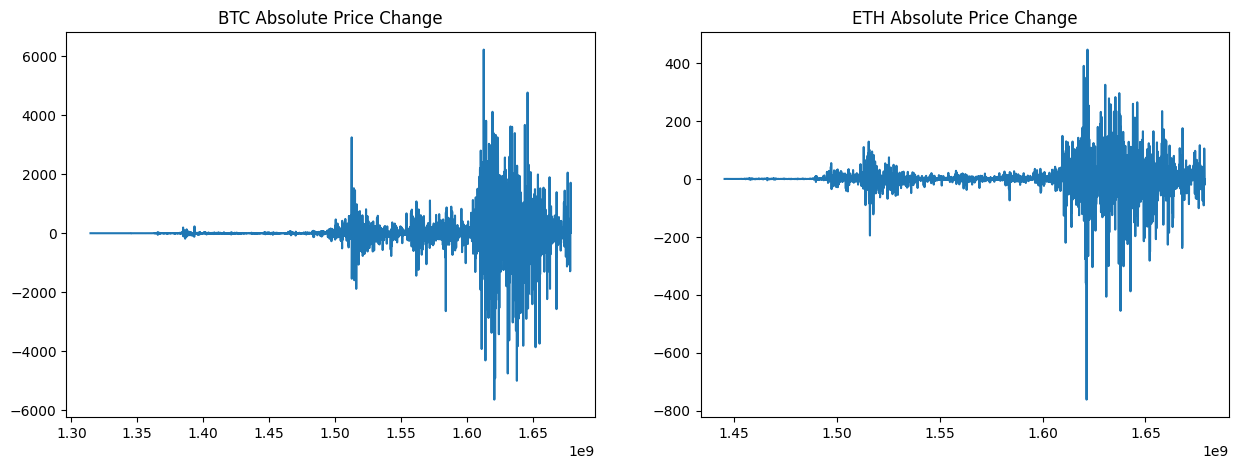

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(btc_targets.btc_price_absolute_change)
ax[0].set_title('BTC Absolute Price Change')
ax[1].plot(eth_targets.eth_price_absolute_change)
ax[1].set_title('ETH Absolute Price Change')
plt.show()

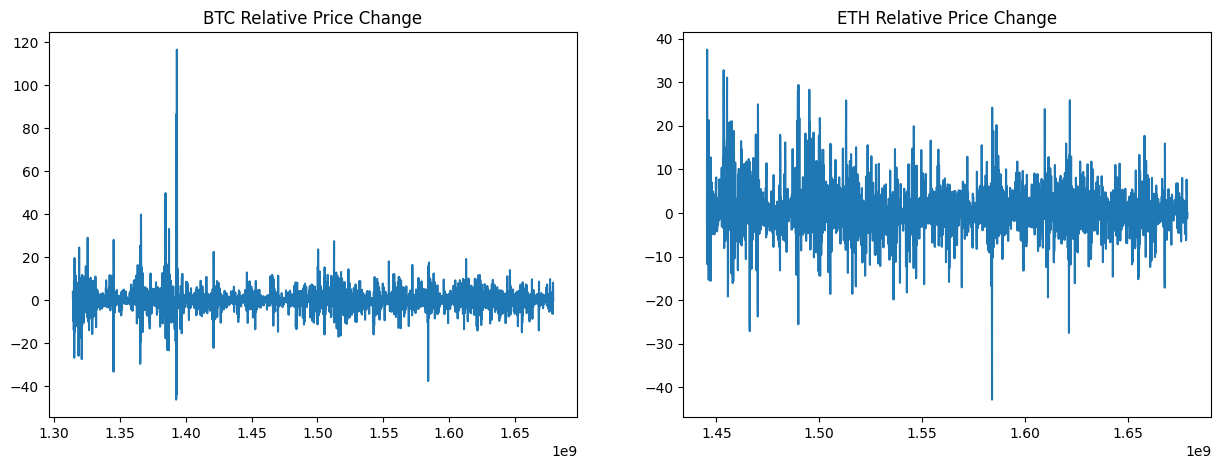

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(btc_targets.btc_price_relative_change);
ax[0].set_title('BTC Relative Price Change')
ax[1].plot(eth_targets.eth_price_relative_change);
ax[1].set_title('ETH Relative Price Change')
plt.show()

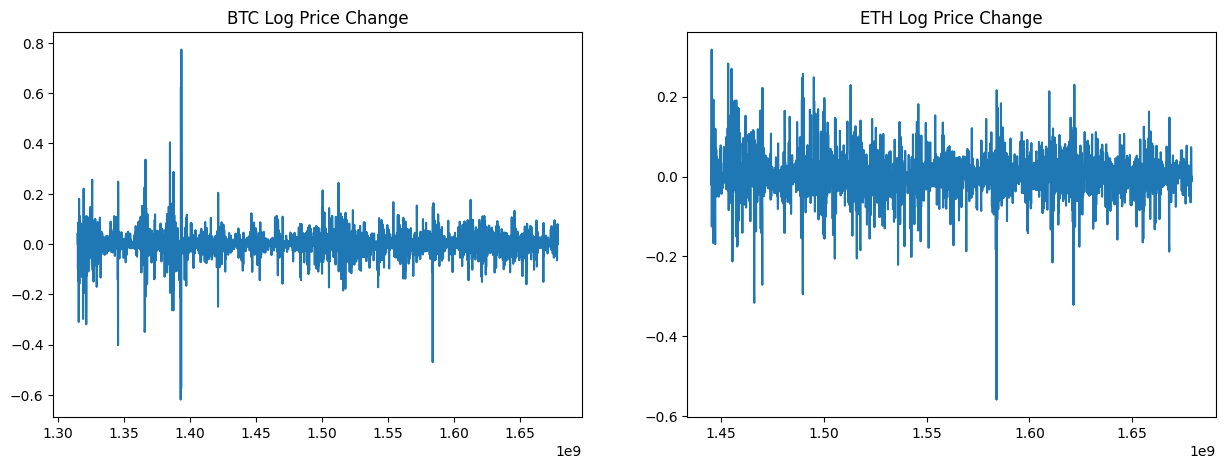

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(btc_targets.btc_price_log_difference);
ax[0].set_title('BTC Log Price Change')
ax[1].plot(eth_targets.eth_price_log_difference);
ax[1].set_title('ETH Log Price Change')
plt.show()

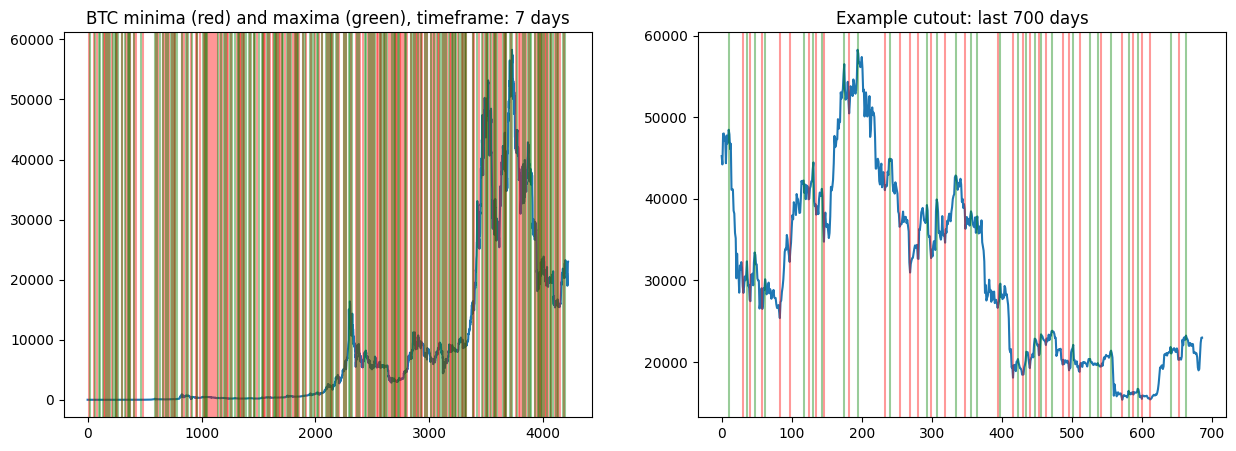

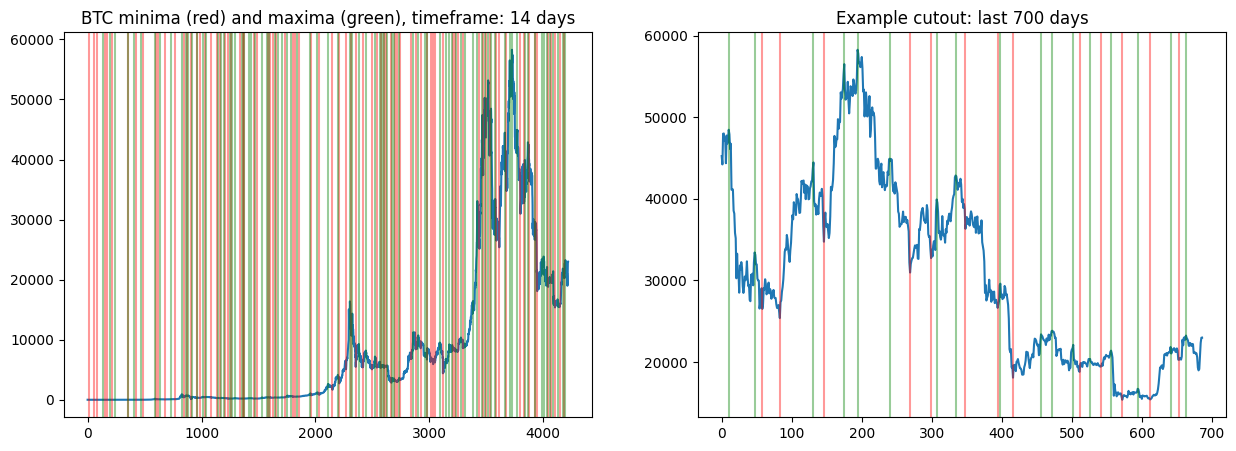

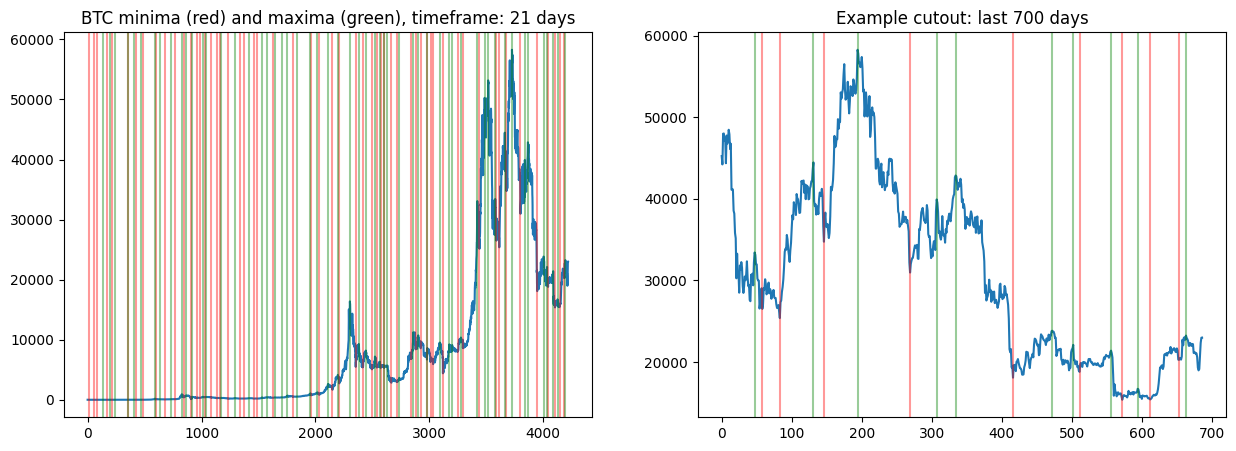

In [10]:
for tf in (7, 14, 21):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    ax[0].plot(btc_data.btc_price_close.reset_index(drop=True))
    for ix in np.nonzero(np.array(btc_targets[f'btc_price_min_{tf}d']))[0]:
        ax[0].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(btc_targets[f'btc_price_max_{tf}d']))[0]:
        ax[0].axvline(ix, color='g', alpha=.4)
    ax[0].set_title(f'BTC minima (red) and maxima (green), timeframe: {tf} days')
    
    tail = 700
    
    ax[1].plot(btc_data.btc_price_close.tail(tail).reset_index(drop=True))
    for ix in np.nonzero(np.array(btc_targets[f'btc_price_min_{tf}d'].tail(tail)))[0]:
        ax[1].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(btc_targets[f'btc_price_max_{tf}d'].tail(tail)))[0]:
        ax[1].axvline(ix, color='g', alpha=.4)
    ax[1].set_title(f'Example cutout: last {tail} days')
    
    plt.show()

### Make visualisation for DSSV slides / Master thesis

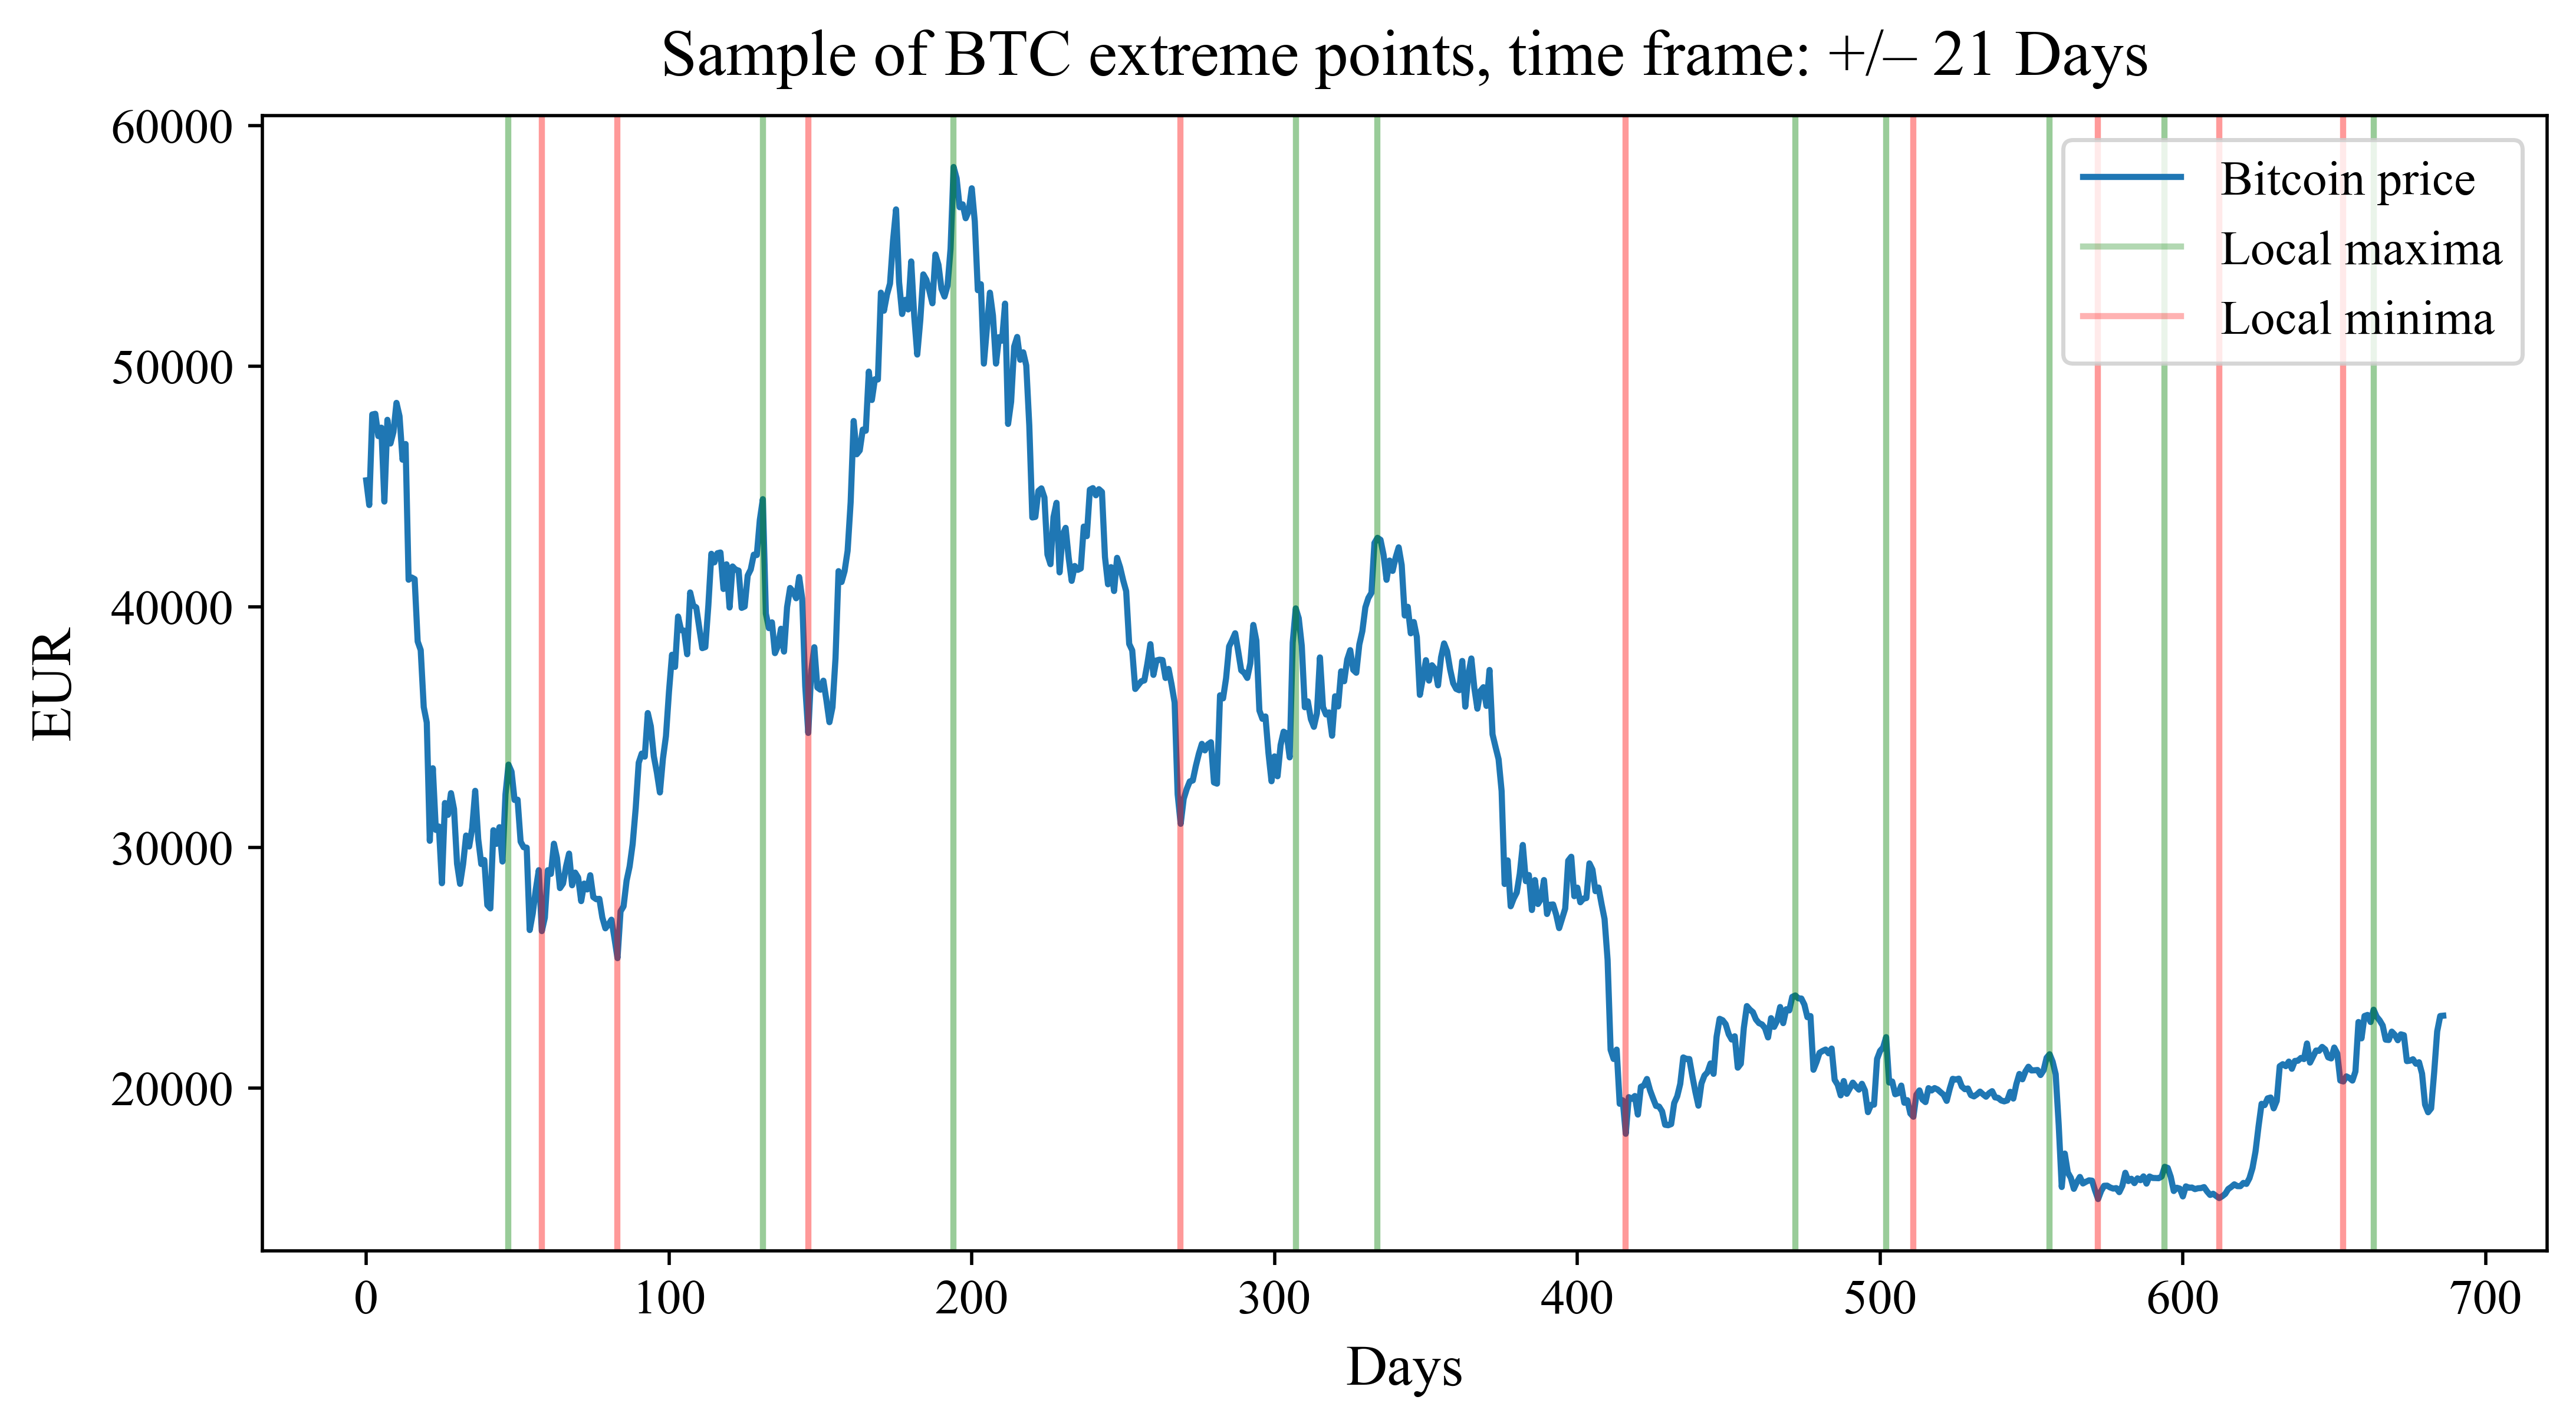

In [11]:
plt.rcParams['figure.dpi'] = 700
plt.rcParams['font.family'] = 'Times New Roman'
plt.rc('legend', fontsize=12)
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=16)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

tf=21
_, ax = plt.subplots(figsize=(10,5), dpi=500)
ax.plot(btc_data.btc_price_close.tail(tail).reset_index(drop=True),
        label='Bitcoin price')
for ix in np.nonzero(np.array(btc_targets[f'btc_price_min_{tf}d'].tail(tail)))[0]:
    ax.axvline(ix, color='r', alpha=.4)
for ix in np.nonzero(np.array(btc_targets[f'btc_price_max_{tf}d'].tail(tail)))[0]:
    ax.axvline(ix, color='g', alpha=.4)
ax.set_title(f'Sample of BTC extreme points, time frame: +/– {tf} Days',
             pad=10)
ax.set_xlabel('Days', labelpad=5)
ax.set_ylabel('EUR', labelpad=7)
handles, _ = ax.get_legend_handles_labels()
handles.extend([
    Line2D([0], [0], label='Local maxima', color='g', alpha=.3),
    Line2D([0], [0], label='Local minima', color='r', alpha=.3),
])
ax.legend(handles=handles, loc='upper right')
plt.show()

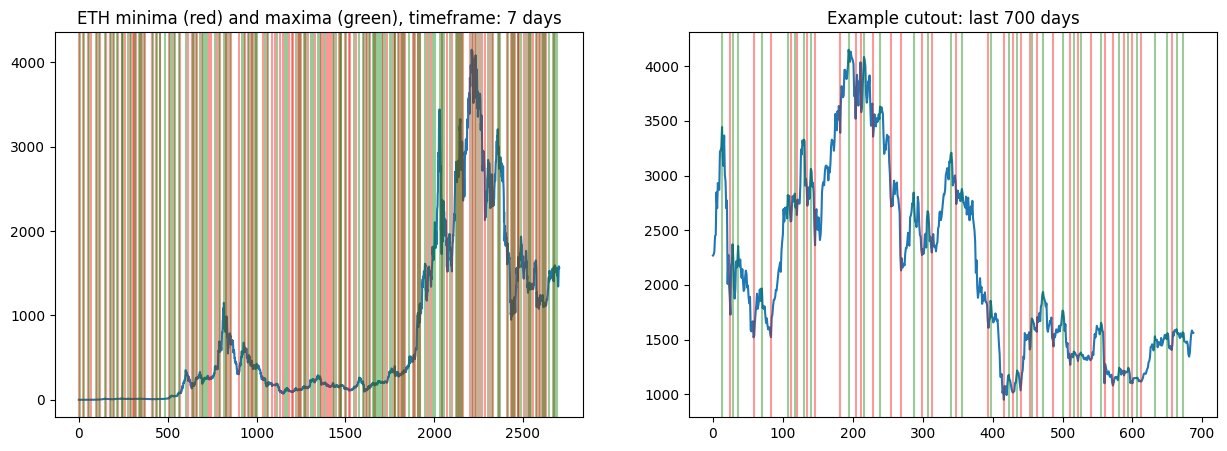

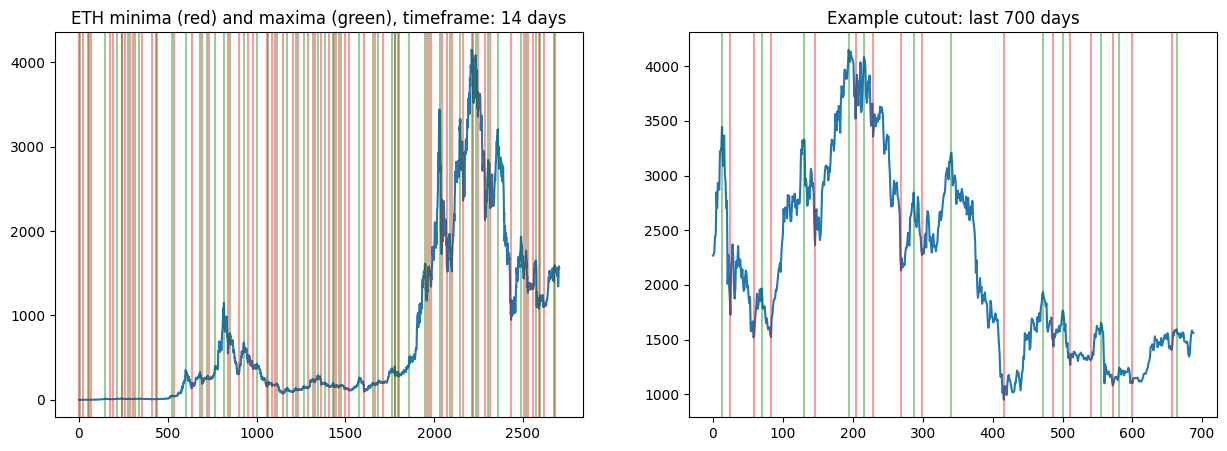

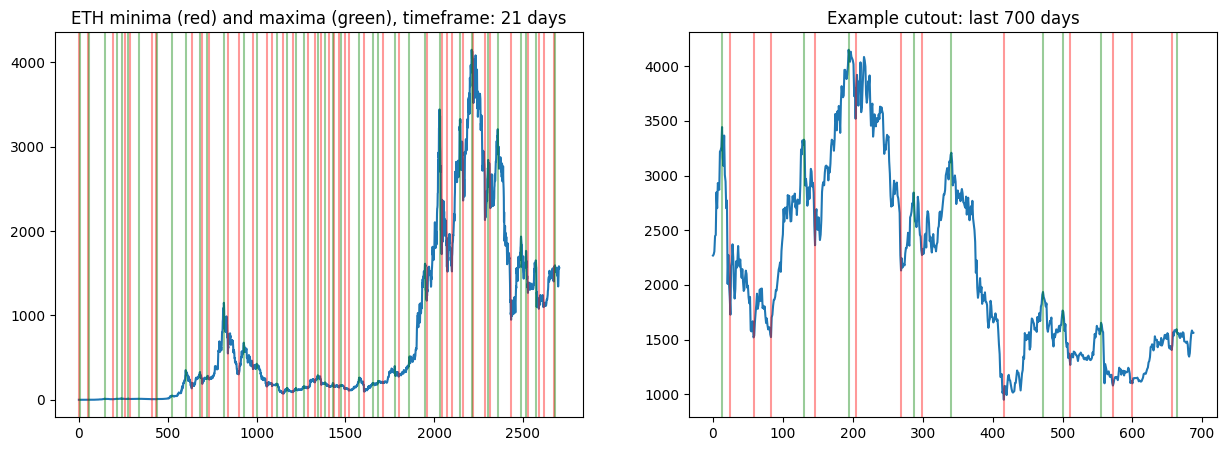

In [49]:
for tf in (7, 14, 21):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    ax[0].plot(eth_data.eth_price_close.reset_index(drop=True))
    for ix in np.nonzero(np.array(eth_targets[f'eth_price_min_{tf}d']))[0]:
        ax[0].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(eth_targets[f'eth_price_max_{tf}d']))[0]:
        ax[0].axvline(ix, color='g', alpha=.4)
    ax[0].set_title(f'ETH minima (red) and maxima (green), timeframe: {tf} days')
    
    tail = 700
    
    ax[1].plot(eth_data.eth_price_close.tail(tail).reset_index(drop=True))
    for ix in np.nonzero(np.array(eth_targets[f'eth_price_min_{tf}d'].tail(tail)))[0]:
        ax[1].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(eth_targets[f'eth_price_max_{tf}d'].tail(tail)))[0]:
        ax[1].axvline(ix, color='g', alpha=.4)
    ax[1].set_title(f'Example cutout: last {tail} days')
    
    plt.show()

### Check stationarity

In [50]:
HeskedTesting.run_all_tests(btc_targets, conf=0.01)

Results of White, Breusch-Pagan and Goldfeld-Quandt tests by column (p-values):

btc_price_absolute_change --   White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
btc_price_relative_change --   White: 0.0018,      Breusch-Pagan: 0.0006,                             Goldfeld-Quandt: 0.0000
btc_price_log_difference --    White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
btc_price_min_7d --            White: 0.3019,      Breusch-Pagan: 0.2169,                             Goldfeld-Quandt: 0.0002
btc_price_max_7d --            White: 0.6481,      Breusch-Pagan: 0.4483,                             Goldfeld-Quandt: 0.0375
btc_price_min_14d --           White: 0.9285,      Breusch-Pagan: 0.7688,                             Goldfeld-Quandt: 0.0319
btc_price_max_14d --           White: 0.3154,      Breusch-Pagan: 0.1409,                             Goldfeld-Quandt: 0.0002
btc_price_min_21d --           White:

In [51]:
HeskedTesting.run_all_tests(eth_targets, conf=0.01)

Results of White, Breusch-Pagan and Goldfeld-Quandt tests by column (p-values):

eth_price_absolute_change --   White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
eth_price_relative_change --   White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
eth_price_log_difference --    White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
eth_price_min_7d --            White: 0.9786,      Breusch-Pagan: 0.8358,                             Goldfeld-Quandt: 0.2471
eth_price_max_7d --            White: 0.8498,      Breusch-Pagan: 0.5718,                             Goldfeld-Quandt: 0.0398
eth_price_min_14d --           White: 0.7847,      Breusch-Pagan: 0.6907,                             Goldfeld-Quandt: 0.5208
eth_price_max_14d --           White: 0.9351,      Breusch-Pagan: 0.9317,                             Goldfeld-Quandt: 0.9875
eth_price_min_21d --           White:

In [52]:
unit_root_testing(btc_targets, conf=0.01)

Results of ADF, PP and KPSS tests by column (p-values):



btc_price_absolute_change --   ADF: 0.0000,        PP: 0.0000,          KPSS: 0.7975
btc_price_relative_change --   ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0823
btc_price_log_difference --    ADF: 0.0000,        PP: 0.0000,          KPSS: 0.2948
btc_price_min_7d --            ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0565
btc_price_max_7d --            ADF: 0.0000,        PP: 0.0000,          KPSS: 0.2562
btc_price_min_14d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9344
btc_price_max_14d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.1052
btc_price_min_21d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.8886
btc_price_max_21d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.8862


In [53]:
unit_root_testing(eth_targets, conf=0.01)

Results of ADF, PP and KPSS tests by column (p-values):

eth_price_absolute_change --   ADF: 0.0000,        PP: 0.0000,          KPSS: 0.7994
eth_price_relative_change --   ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0056
eth_price_log_difference --    ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0191
eth_price_min_7d --            ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9258
eth_price_max_7d --            ADF: 0.0000,        PP: 0.0000,          KPSS: 0.4456
eth_price_min_14d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.8878
eth_price_max_14d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9958
eth_price_min_21d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9003
eth_price_max_21d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9503


In [54]:
btc_targets = btc_targets.drop(columns=['btc_price_absolute_change', 'btc_price_relative_change'])
eth_targets = eth_targets.drop(columns=['eth_price_absolute_change', 'eth_price_relative_change'])

### Shift targets back one day and limit timeframe to where all data is available

In [55]:
btc_price_data = btc_targets.loc[1314662400:1678752000][['btc_price_log_difference']]
eth_price_data = eth_targets.loc[1445472000:1678838400][['eth_price_log_difference']]

In [56]:
btc_price_data.to_parquet('btc_price_data.parquet.gzip',
                       compression='gzip')

eth_price_data.to_parquet('eth_price_data.parquet.gzip',
                       compression='gzip')

In [57]:
btc_targets_unshifted = btc_targets.loc[1314662400:1678752000]
eth_targets_unshifted = eth_targets.loc[1445472000:1678838400]

In [58]:
btc_targets_unshifted.to_parquet('btc_targets_unshifted.parquet.gzip',
                                 compression='gzip')

eth_targets_unshifted.to_parquet('eth_targets_unshifted.parquet.gzip',
                                 compression='gzip')


In [59]:
btc_targets = btc_targets.shift(-1).loc[1314662400:1678752000]
eth_targets = eth_targets.shift(-1).loc[1445472000:1678838400]

In [60]:
btc_targets.to_parquet('btc_targets.parquet.gzip',
                       compression='gzip')

eth_targets.to_parquet('eth_targets.parquet.gzip',
                       compression='gzip')